In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import joblib

plt.rcParams["figure.figsize"] = (3,3.5)

In [2]:
def load_data(directory, datafilename):
  try:
    f = open(f'{directory}/{datafilename}.csv', 'r')
  except FileNotFoundError:
    print('data file is missing. generating now.')
    if 'D0' in directory or 'D1' in directory:
      os.system(f'python D0D1_generation.py')
    else:
      os.system(f'python {directory}_generation.py')
    print('file generated.')
    f = open(f'{directory}/{datafilename}.csv', 'r')
  data = np.array(
      [[float(item2) for item2 in item.split(',') if len(item2)>0]
       for item in f.read().split('\n')[1:] if len(item)>0]  # includes the ID column also
  )
  return data


SVM


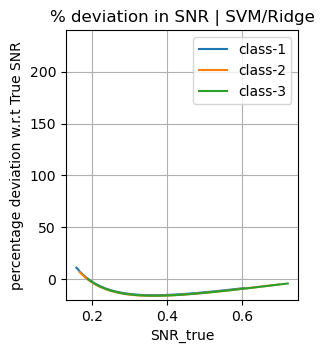


KNN


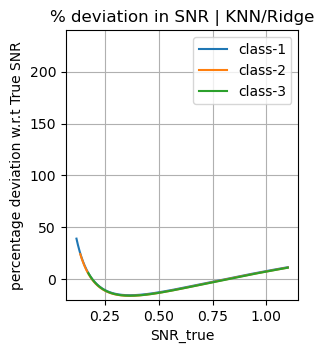


LogReg


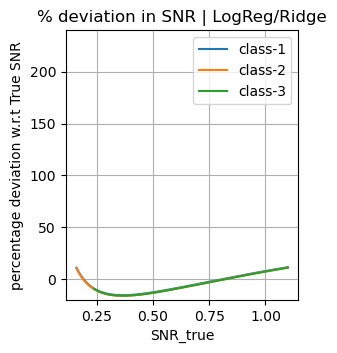


GaussNB


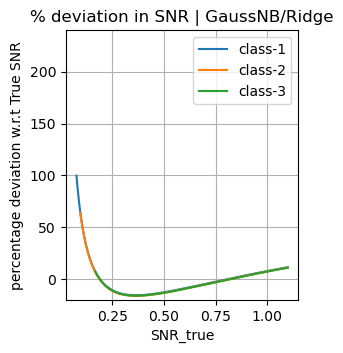


DT


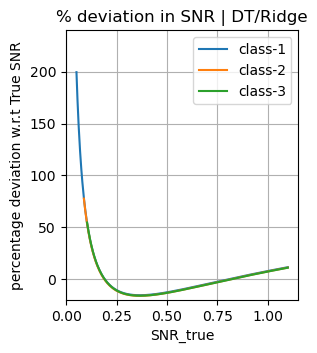

SVM
label = 1	-15.7%	10.9%
label = 2	-16.2%	6.6%
label = 3	-16.2%	0.0%
KNN
label = 1	-15.7%	38.9%
label = 2	-16.2%	24.0%
label = 3	-16.2%	10.9%
LogReg
label = 1	-15.7%	11.4%
label = 2	-16.2%	11.0%
label = 3	-16.2%	10.9%
GaussNB
label = 1	-15.7%	99.7%
label = 2	-16.2%	64.0%
label = 3	-16.2%	10.9%
DT
label = 1	-15.7%	199.5%
label = 2	-16.2%	77.6%
label = 3	-16.2%	54.5%



In [3]:
'''
experimental data (D2) is tested for SNR estimation
this is two step algorithm
first the class is identified from "obj1" models
then SNR is estimayet
Hence, evaluation is over all classification models followed by Ridge
'''

model_list = ['SVM', 'KNN', 'LogReg', 'GaussNB', 'DT']#['SVM', 'KNN', 'LogReg', 'GaussNB', 'DT']

results = ''

for [directory, datafilename] in [['D2', 'testD2']]:

  data = load_data(directory, f'{datafilename}_detailed')

  for model_tag in model_list:
    print(f'\n{model_tag}')
    results += f'{model_tag}\n'

    X, y = data[:, 1:1017], data[:, 1017:1018]
    X_copy = X  # backup, since SNR estimation model uses non-transformed X

    model = joblib.load(f'final_{model_tag}.joblib')
    scalar = joblib.load(f'final_{model_tag}_scaler.joblib')
    
    X = scalar.fit_transform(X)
    y_pred = model.predict(X)
    
    regressor_1 = joblib.load(f'SNR_Ridge_class1_Exp.joblib')
    regressor_2 = joblib.load(f'SNR_Ridge_class2_Exp.joblib')
    regressor_3 = joblib.load(f'SNR_Ridge_class3_Exp.joblib')

    SNR = data[:, -1]  # during data generation "SNR" was also saved in filename with suffix "detailed"

    sorted_indices = np.argsort(SNR)  # for error variation w.r.t SNR value, we sort data by SNR value
    X_copy = X_copy[sorted_indices]
    y_pred = y_pred[sorted_indices]
    SNR = SNR[sorted_indices]
    
    SNR_true = [[], [], []]
    SNR_pred = [[], [], []]
    for i in range(X_copy.shape[0]):
      x = X_copy[i, :]
      x = x.reshape(1,-1)
      pred_label = int(y_pred[i])
      if pred_label == 0: continue
      if pred_label == 1: regressor = regressor_1
      if pred_label == 2: regressor = regressor_2
      if pred_label == 3: regressor = regressor_3
      SNR_true[pred_label-1].append(SNR[i])
      SNR_pred[pred_label-1].append(regressor.predict(x)[0])  # the prediction is nested
    
    deviation = []
    for label in [1, 2, 3]:
      SNR_true_label = np.array(SNR_true[label-1])
      SNR_pred_label = np.array(SNR_pred[label-1])
      mse = mean_squared_error(SNR_true_label, SNR_pred_label)
      deviation.append(100*(SNR_true_label-SNR_pred_label)/SNR_true_label)
    for label in [1, 2, 3]:
      min_dev = f'{round(deviation[label-1].min(), 1)}%'
      max_dev = f'{round(deviation[label-1].max(), 1)}%'
      results += f'label = {label}\t{min_dev}\t{max_dev}\n'
      plt.plot(np.array(SNR_true[label-1]), deviation[label-1],
               label = f'class-{label}')
    plt.grid()
    plt.legend()
    plt.xlabel('SNR_true')
    plt.ylabel('percentage deviation w.r.t True SNR')
    plt.title(f'% deviation in SNR | {model_tag}/Ridge')
    plt.ylim(-20, 240)
    plt.show()
f = open('SNR_Ridge_results.txt', 'w')
f.write(results)
f.close()
print(results)